In [216]:
import datetime

import matplotlib as mp
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

sns.set()
sns.set_style('whitegrid')
sns.set_style('ticks')

# data

In [6]:
# https://data.sfgov.org/Housing-and-Buildings/Planning-Department-Records/7yuw-98m5
# csv: https://data.sfgov.org/api/views/kgai-svwy/rows.csv?accessType=DOWNLOAD
# glossary: http://default.sfplanning.org/GIS/DataSF_PPTS_Fields.xlsx

fields = pd.read_csv('planning-department-records/DataSF_PPTS_Fields.csv')
data = pd.read_csv('planning-department-records/PPTS_Records_data.csv',
                   parse_dates=[
                       'date_opened',
                       'date_closed',
                   ],
                   infer_datetime_format=True)

In [32]:
# prj is a decent first-approximation of the first time planning learns about a project
prj = data[data['record_type_category'] == 'PRJ']

In [101]:
# Find all projects with any units proposed
market_res_units = [
    'PRJ_FEATURE_MARKET_RATE_EXIST',
    'PRJ_FEATURE_MARKET_RATE_PROP',
    'PRJ_FEATURE_MARKET_RATE_NET',
]
aff_res_units = [
    'PRJ_FEATURE_AFFORDABLE_EXIST',
    'PRJ_FEATURE_AFFORDABLE_PROP',
    'PRJ_FEATURE_AFFORDABLE_NET',
]

res_units = market_res_units + aff_res_units

q = ~pd.isna(prj[res_units[0]])
for r in res_units[1:]:
    q |= ~pd.isna(prj[r])
prj_res = prj[q]

In [108]:
# Unfortunately, planning is missing data for anything before 2014 Q4
prj_res = prj_res[prj_res.date_opened >= datetime.datetime(2014,10,1)]

In [109]:
len(prj_res)

3531

In [160]:
def quarter(dt):
    return "%s Q%s" % (dt.year, int(np.ceil((dt.month-1)/3)) + 1)


def half(dt):
    return "%s H%s" % (dt.year, int(np.ceil((dt.month-1)/6)) + 1)


def monthyear(dt):
    return "%s %s" % (dt.year, dt.strftime("%b"))

In [161]:
prj_res['_year'] = prj_res['date_opened'].apply(lambda dt: str(dt.year))
prj_res['_quarter'] = prj_res['date_opened'].apply(quarter)
prj_res['_half'] = prj_res['date_opened'].apply(half)
prj_res['_month'] = prj_res['date_opened'].apply(monthyear)

# Analysis

In [226]:
before = prj_res[prj_res.date_opened < datetime.datetime(2016,7,1)]
after = prj_res[prj_res.date_opened >= datetime.datetime(2016,7,1)]

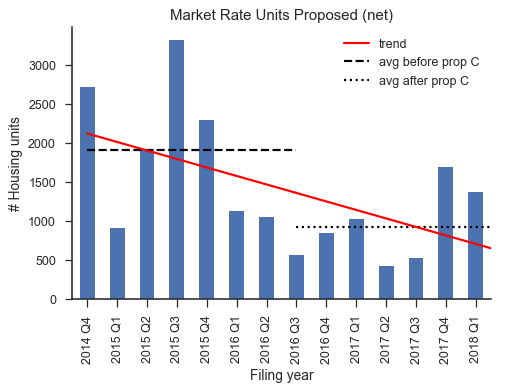

In [340]:
mrk_data = prj_res.groupby('_quarter').aggregate({'PRJ_FEATURE_MARKET_RATE_NET': 'sum'})
d = mrk_data.PRJ_FEATURE_MARKET_RATE_NET.values.tolist()
params = np.polyfit(range(len(d)), d, 1)
poly = np.poly1d(params)

mrk_data_before = before.groupby('_quarter').aggregate({'PRJ_FEATURE_MARKET_RATE_NET': 'sum'})
d = mrk_data_before.PRJ_FEATURE_MARKET_RATE_NET.values.tolist()
offset = len(d)
avg_before = np.mean(d)

mrk_data_after = after.groupby('_quarter').aggregate({'PRJ_FEATURE_MARKET_RATE_NET': 'sum'})
d = mrk_data_after.PRJ_FEATURE_MARKET_RATE_NET.values.tolist()
avg_after = np.mean(d)

f = mp.pyplot.figure()
ax = f.gca()
p = mrk_data.plot.bar(ax=ax)
p.set_label("_nolegend_")

xp = np.linspace(0, len(mrk_data.PRJ_FEATURE_MARKET_RATE_NET.values), 20)
l1 = ax.plot(xp, poly(xp), label='trend', color='red')
l2 = ax.hlines(avg_before, 0, offset, label='avg before', linestyles='dashed')
l3 = ax.hlines(avg_after, offset, len(d) + offset, label='avg after', linestyles='dotted')
mp.pyplot.title("Market Rate Units Proposed (net)")
ax.set_ylabel("# Housing units")
ax.set_xlabel("Filing year")
#ax.legend()
ax.legend((l1[0], l2, l3), ('trend', 'avg before prop C', 'avg after prop C'))
sns.despine()
f.set_dpi(90)

In [ ]:
aff_data = prj_res.groupby('_quarter').aggregate({'PRJ_FEATURE_AFFORDABLE_NET': 'sum'})
d = aff_data.PRJ_FEATURE_AFFORDABLE_NET.values.tolist()
params = np.polyfit(range(len(d)), d, 1)
poly = np.poly1d(params)

aff_data_before = before.groupby('_quarter').aggregate({'PRJ_FEATURE_AFFORDABLE_NET': 'sum'})
d = aff_data_before.PRJ_FEATURE_AFFORDABLE_NET.values.tolist()
offset = len(d)
avg_before = np.mean(d)

aff_data_after = after.groupby('_quarter').aggregate({'PRJ_FEATURE_AFFORDABLE_NET': 'sum'})
d = aff_data_after.PRJ_FEATURE_AFFORDABLE_NET.values.tolist()
avg_after = np.mean(d)

f = mp.pyplot.figure()
ax = f.gca()
p = mrk_data.plot.bar(ax=ax)
p.set_label("_nolegend_")

xp = np.linspace(0, len(aff_data.PRJ_FEATURE_AFFORDABLE_NET.values), 20)
l1 = ax.plot(xp, poly(xp), label='trend', color='red')
l2 = ax.hlines(avg_before, 0, offset, label='avg before', linestyles='dashed')
l3 = ax.hlines(avg_after, offset, len(d) + offset, label='avg after', linestyles='dotted')
mp.pyplot.title("Affordable Units Proposed (net)")
ax.set_ylabel("# Housing units")
ax.set_xlabel("Filing year")
#ax.legend()
ax.legend((l1[0], l2, l3), ('trend', 'avg before prop C', 'avg after prop C'))
sns.despine()
f.set_dpi(90)

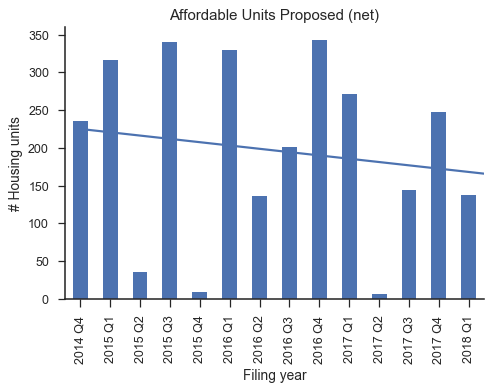

In [298]:
aff_data = prj_res.groupby('_quarter').aggregate({'PRJ_FEATURE_AFFORDABLE_NET': 'sum'})
d = aff_data.PRJ_FEATURE_AFFORDABLE_NET.values.tolist()
x = range(len(d))
params = np.polyfit(x, d, 1)
poly = np.poly1d(params)

f = mp.pyplot.figure()
ax = f.gca()
p = aff_data.plot.bar(ax=ax, legend=None)
xp = np.linspace(0, len(aff_data.PRJ_FEATURE_AFFORDABLE_NET.values), 20)
ax.plot(xp, poly(xp))
mp.pyplot.title("Affordable Units Proposed (net)")
ax.set_ylabel("# Housing units")
ax.set_xlabel("Filing year")
sns.despine()
f.set_dpi(90)

In [245]:
mrk_regression = sm.OLS(mrk_data.PRJ_FEATURE_MARKET_RATE_NET.values, range(len(mrk_data))).fit()
mrk_regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     6.907
Date:                Tue, 24 Apr 2018   Prob (F-statistic):             0.0209
Time:                        22:26:04   Log-Likelihood:                -120.54
No. Observations:                  14   AIC:                             243.1
Df Residuals:                      13   BIC:                             243.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           126.4774     48.126      2.628      0.021      22.509     230.446
==============================================================================
Omnibus:                        2.002   Durbin-Watson:                   0.465
Prob(Omnibus):                  0.367   Jarque-Bera (JB):                1.511
Skew:                           0.731   Prob(JB):                        0.470
Kurtosis:                       2.325   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [244]:
aff_regression = sm.OLS(aff_data.PRJ_FEATURE_AFFORDABLE_NET.values, range(len(aff_data))).fit()
aff_regression.summary()
aff_regression.fittedvalues

array([  0.        ,  20.61538462,  41.23076923,  61.84615385,
        82.46153846, 103.07692308, 123.69230769, 144.30769231,
       164.92307692, 185.53846154, 206.15384615, 226.76923077,
       247.38461538, 268.        ])

In [267]:
mdata

rec.array([(1959., 1.,  2710.349, 1707.4,  286.898,  470.045,  1886.9,  28.98 ,  139.7,  2.82,  5.8, 177.146,  0.  ,  0.  ),
           (1959., 2.,  2778.801, 1733.7,  310.859,  481.301,  1919.7,  29.15 ,  141.7,  3.08,  5.1, 177.83 ,  2.34,  0.74),
           (1959., 3.,  2775.488, 1751.8,  289.226,  491.26 ,  1916.4,  29.35 ,  140.5,  3.82,  5.3, 178.657,  2.74,  1.09),
           (1959., 4.,  2785.204, 1753.7,  299.356,  484.052,  1931.3,  29.37 ,  140. ,  4.33,  5.6, 179.386,  0.27,  4.06),
           (1960., 1.,  2847.699, 1770.5,  331.722,  462.199,  1955.5,  29.54 ,  139.6,  3.5 ,  5.2, 180.007,  2.31,  1.19),
           (1960., 2.,  2834.39 , 1792.9,  298.152,  460.4  ,  1966.1,  29.55 ,  140.2,  2.68,  5.2, 180.671,  0.14,  2.55),
           (1960., 3.,  2839.022, 1785.8,  296.375,  474.676,  1967.8,  29.75 ,  140.9,  2.36,  5.6, 181.528,  2.7 , -0.34),
           (1960., 4.,  2802.616, 1788.2,  259.764,  476.434,  1966.6,  29.84 ,  141.1,  2.29,  6.3, 182.287,  1.21,  1.08),


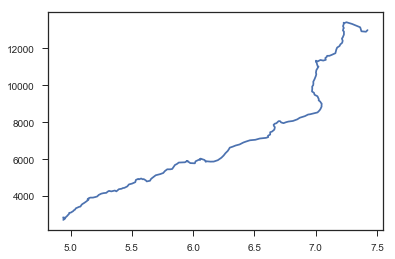

In [268]:
f = mp.pyplot.figure()
ax = f.gca()
ax.plot(endog, mdata['realgdp'])

In [250]:
tsa = sm.tsa

mdata = sm.datasets.macrodata.load().data
endog = np.log(mdata['m1'])
exog = np.column_stack([np.log(mdata['realgdp']), np.log(mdata['cpi'])])
exog = sm.add_constant(exog, prepend=True)
res1 = sm.OLS(endog, exog).fit()
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     9871.
Date:                Wed, 25 Apr 2018   Prob (F-statistic):          1.34e-200
Time:                        08:33:36   Log-Likelihood:                 221.75
No. Observations:                 203   AIC:                            -437.5
Df Residuals:                     200   BIC:                            -427.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5016      0.353     -4.256      0.0